# now we have results for several models

Let's make sure it's saved correctly and let's evaluate

In [1]:
import os
os.listdir('/data1/lesliec/sarthak/data/joint_playground/caQTL')

['QTD100018.permuted.tsv',
 'base_model.zarr',
 'QTD100018.all_subset_peaks_nearby.tsv',
 'QTD100018.subset.tsv',
 'QTD100018.all_subset_peaks.tsv',
 'QTD100018.all_subset.tsv',
 'caqtls.eu.lcls.benchmarking.all.tsv',
 'nomlm_maskonly_0.zarr',
 'nomlm_maskonly.zarr',
 'immune_nob_maskonly_nomlm.zarr',
 'QTD100018.all.tsv',
 'QTD100018_peak_metadata.tsv',
 'caqtls.eu.lcls.benchmarking.all.README']

In [5]:
import zarr
base = zarr.open('/data1/lesliec/sarthak/data/joint_playground/caQTL/base_model.zarr', mode='r')[:]
base.shape

(95065, 500, 2)

In [18]:
#find how many values in base are nan
import numpy as np
nan_count = np.sum(np.isnan(base))
nan_count

0

In [13]:
#let's see if any samples are zero
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from scipy.spatial.distance import jensenshannon

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2

def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()

In [15]:
qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/caQTL/caqtls.eu.lcls.benchmarking.all.tsv', sep='\t')
qtls = qtls[qtls['var.isused'] == 1]
qtls

,var.chr,var.pos_hg38,var.allele1,var.allele2,obs.beta,obs.pval,var.isused,pred.enformer.encsr000emt.variantscore.global_sad,pred.enformer.encsr000emt.variantscore.global_sar,pred.chrombpnet.encsr637xsc.variantscore.logfc,pred.chrombpnet.encsr637xsc.variantscore.jsd,pred.chrombpnet.encsr637xsc.variantscore.ips,pred.chrombpnet.encsr637xsc_50m.variantscore.logfc,pred.chrombpnet.encsr637xsc_50m.variantscore.jsd,pred.chrombpnet.encsr637xsc_50m.variantscore.ips,pred.chrombpnet.encsr000emt.variantscore.logfc,pred.chrombpnet.encsr000emt.variantscore.jsd,pred.chrombpnet.encsr000emt.variantscore.ips,pred.enformer.encsr000emt.variantscore.local_logfc,var.rsid
15,chr1,817186,G,A,-0.090801,6.684890e-01,True,0.000040,0.000053,-0.044882,0.006798,0.000171,-0.041416,0.007593,0.000156,-0.030728,0.009934,0.000173,0.018470,chr1_817186_G_A
16,chr1,817213,T,G,0.318039,4.479090e-01,True,-0.000041,-0.000055,-0.003092,0.012010,0.000198,-0.018905,0.021295,0.000284,-0.009320,0.015260,0.000227,-0.091478,chr1_817213_T_G
17,chr1,817237,C,A,0.318039,4.479090e-01,True,0.000090,0.000120,-0.058956,0.007501,0.000272,-0.041379,0.008352,0.000192,-0.022268,0.013804,0.000202,0.025526,chr1_817237_C_A
18,chr1,817341,A,G,-0.090801,6.684890e-01,True,0.002493,0.003319,0.493997,0.036021,0.012484,0.369473,0.047510,0.012412,0.338401,0.047837,0.012469,0.391526,chr1_817341_A_G
23,chr1,827252,T,A,0.472063,1.573590e-02,True,0.001834,0.002441,0.119246,0.016683,0.001942,0.069721,0.022702,0.001508,0.068678,0.019208,0.001369,0.101590,chr1_827252_T_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107401,chr6,132872919,T,C,-0.021516,7.966860e-01,True,-0.000118,-0.000160,0.005472,0.005791,0.000025,0.004359,0.004415,0.000008,0.006893,0.007502,0.000026,0.003325,chr6_132872919_T_C
107402,chr6,133115168,C,T,-0.267922,4.677510e-02,True,-0.000010,-0.000014,-0.186435,0.015016,0.001443,-0.173224,0.013539,0.000895,-0.129991,0.026472,0.001503,0.018382,chr6_133115168_C_T
107403,chr6,133159287,T,A,0.914801,3.228120e-09,True,0.000015,0.000021,0.107819,0.022100,0.000846,0.100229,0.022341,0.000552,0.028835,0.018326,0.000262,0.001704,chr6_133159287_T_A
107404,chr6,133159461,G,A,0.914801,3.228120e-09,True,0.000061,0.000085,0.169042,0.015526,0.000981,0.068422,0.010637,0.000186,0.088131,0.016072,0.000612,0.014187,chr6_133159461_G_A


In [16]:
#labels are labels[obs.pval < 1e-6]
labels = np.zeros(len(qtls))
labels[qtls['obs.pval'] < 1e-6] = 1
labels.sum(), len(labels) - labels.sum(), len(labels)

(7900.0, 87165.0, 95065)

/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/spatial/distance.py:1259: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


ValueError: Input contains NaN.

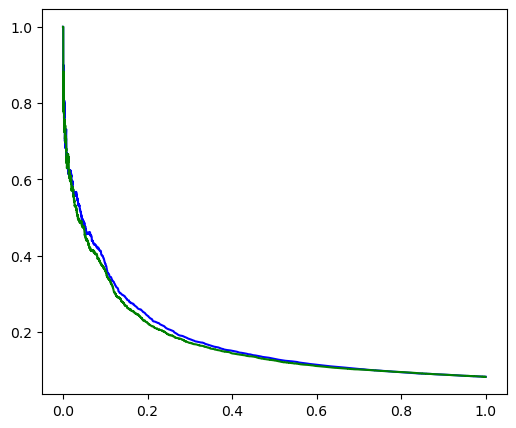

In [17]:
out = predict_snp_effect_scores(base[:,:,0], base[:,:,1])
plot_metrics(out, labels, 'Joint model: base')

In [20]:
#what's the issue with the sqrt?
probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(base[:,:,0], base[:,:,1])])
probs_jsd_diff.shape

/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/spatial/distance.py:1259: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


(95065,)

In [ ]:
np.isnan(probs_jsd_diff).sum(), np.isinf(probs_jsd_diff).sum()
#why are so many nan??

(18200, 0)

/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/spatial/distance.py:1259: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


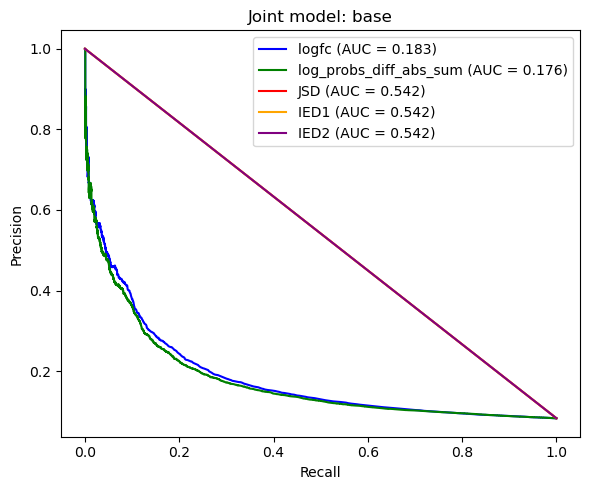

In [ ]:
#let's find how many are exactly identical...
out = predict_snp_effect_scores(base[:,:,0], base[:,:,1])
out = list(out)
out[2] = np.zeros_like(out[2]) #contains nan for some reason wtf?
out[3] = np.zeros_like(out[3])
out[4] = np.zeros_like(out[4])
plot_metrics(out, labels, 'Joint model: base')

/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/spatial/distance.py:1259: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


found nan in probs_jsd_diff


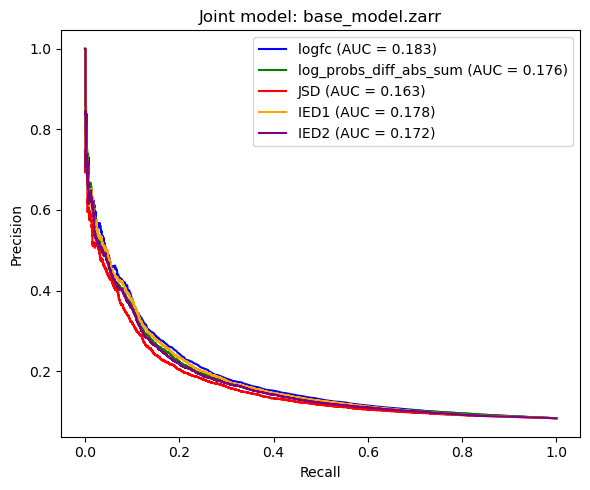

/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/spatial/distance.py:1259: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


found nan in probs_jsd_diff


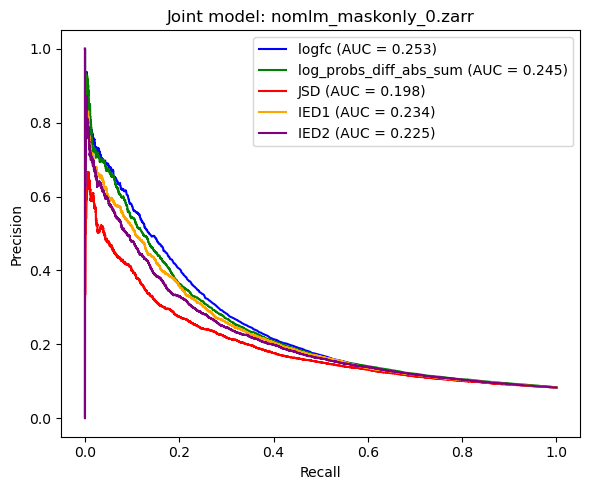

/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/spatial/distance.py:1259: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


found nan in probs_jsd_diff


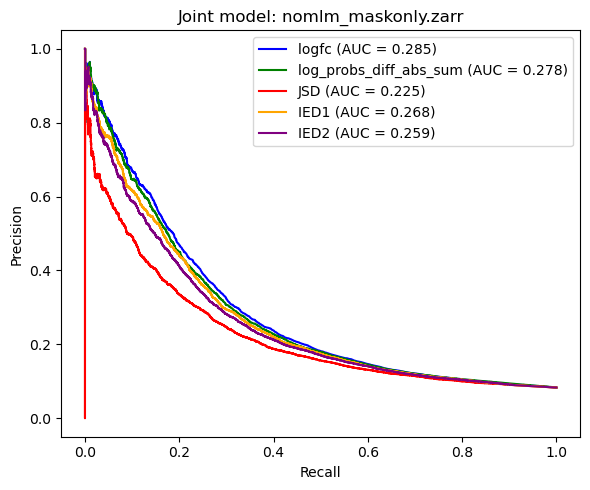

/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/spatial/distance.py:1259: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


found nan in probs_jsd_diff


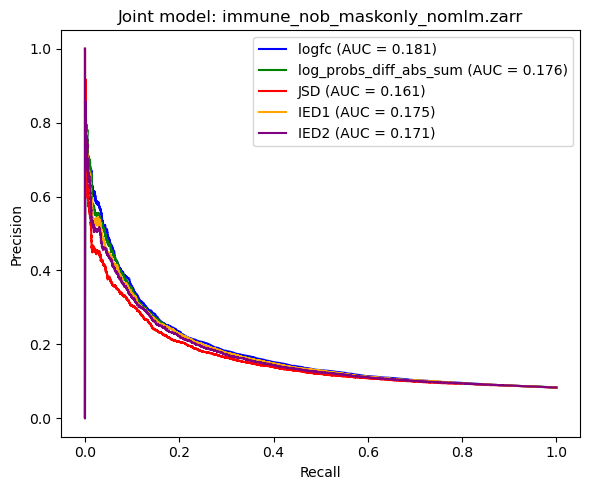

In [25]:
#now let's do some more models
def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    if np.isnan(probs_jsd_diff).sum() > 0:
        print('found nan in probs_jsd_diff')
        probs_jsd_diff[np.isnan(probs_jsd_diff)] = 0
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2

files = ['base_model.zarr','nomlm_maskonly_0.zarr',
 'nomlm_maskonly.zarr',
 'immune_nob_maskonly_nomlm.zarr']

for file in files:
    base = zarr.open(f'/data1/lesliec/sarthak/data/joint_playground/caQTL/{file}', mode='r')[:]
    # print(file)
    # print(base.shape)
    out = predict_snp_effect_scores(base[:,:,0], base[:,:,1])
    plot_metrics(out, labels, f'Joint model: {file}')